![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Importación de librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

La estación con el mayor promedio de alquileres de bicicletas es la temporada 3 (verano), seguida por la temporada 2 (primavera).
La temporada con el menor promedio de alquileres es la temporada 1 (invierno), seguida por la temporada 4 (otoño).

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Las horas con los mayores promedios de alquiler de bicicletas son las horas pico de la mañana (7:00 - 9:00) y de la tarde (16:00 - 18:00).
Las horas con los menores promedios de alquiler son las horas de la madrugada (2:00 - 5:00).
El máximo promedio de alquileres ocurre a las 17:00 horas.
El mínimo promedio de alquileres se observa a las 4:00 horas.

Otras métricas que complementan el análisis son:

In [8]:
# Para la variable 'season'
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


Su puede observar que las estaciones de verano y otoño presentan los mayores promedios de alquiler, con aproximadamente 215 y 234 respectivamente, seguidas por la primavera y el invierno con promedios de alrededor de 116 y 199 respectivamente. Por ende, para ser que, hay una mayor demanda de alquiler de bicicletas durante los meses más cálidos y templados. Además, las estaciones de verano y otoño muestran una mayor dispersión en los datos, como se evidencia por sus desviaciones estándar más altas en comparación con la primavera y el invierno. Lo cual podría indicar una mayor variabilidad en los patrones de uso de bicicletas durante estas estaciones, posiblemente influenciada por factores como eventos estacionales, festivos o turísticos.

In [9]:
# Para la variable 'hour'
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Con respecto a la variable "hour", se observa que el promedio de alquiler de bicicletas varía considerablemente a lo largo del día. Las horas con los promedios más bajos de alquiler son entre la 3 a.m. y las 5 a.m., con valores que oscilan entre aproximadamente 6 y 12 alquileres. Posteriormente, se observa un aumento gradual en la demanda de bicicletas, alcanzando su punto máximo durante las horas de la tarde, entre las 4 p.m. y las 6 p.m., con promedios superiores a 400 alquileres por hora. Este patrón sugiere que la demanda de bicicletas aumenta significativamente durante las horas pico, posiblemente debido a las actividades laborales y de ocio que se realizan durante este período. Además, se observa una mayor dispersión en los datos durante las horas de mayor demanda, que se evidencia por las desviaciones estándar más altas, lo que sugiere una mayor variabilidad en los patrones de uso de bicicletas durante estas horas.


Con el fin de explorar la distribución de los alquileres de bicicletas en diferentes momentos del día y durante las diferentes estaciones del año, se presentan los siguientes histogramas, los cuales resultan ser muy homogeneos. 

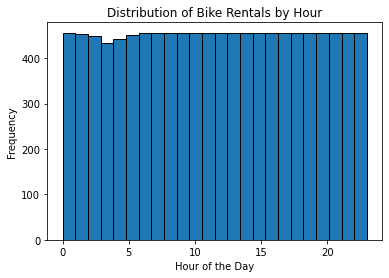

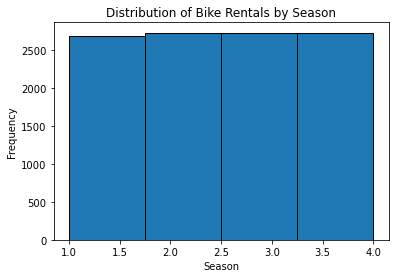

In [10]:
# Histograma para la variable 'hour'
plt.hist(bikes['hour'], bins=24, edgecolor='black')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Rentals by Hour')
plt.show()

# Histograma para la variable 'season'
plt.hist(bikes['season'], bins=4, edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Rentals by Season')
plt.show()


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

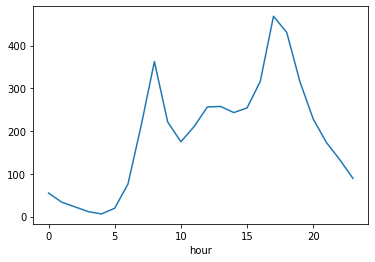

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Esta visualización muestra la tendencia del promedio de alquiler de bicicletas a lo largo del día. Se puede observar un patrón bimodal, con picos durante las horas de la mañana y la tarde, que coinciden con los períodos de mayor actividad laboral y de ocio. Durante las horas de la madrugada y la noche, se registra una disminución en el promedio de alquiler, reflejando una menor demanda de bicicletas durante estas horas. Este patrón sugiere que el alquiler de bicicletas está influenciado por los horarios de trabajo y actividades recreativas de las personas.

<Axes: xlabel='hour'>

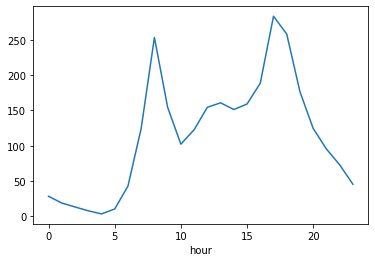

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

# Filtrar datos para la estación de invierno (season = 1)
bikes_invierno = bikes[bikes['season'] == 1]

# Graficar el número de bicicletas rentadas promedio para cada hora en invierno
bikes_invierno.groupby('hour').total.mean().plot()

En invierno, se observa un patrón de alquiler de bicicletas con una demanda más baja durante las primeras horas de la mañana, seguido de un aumento gradual hacia el mediodía y una disminución durante la tarde y la noche.

<Axes: xlabel='hour'>

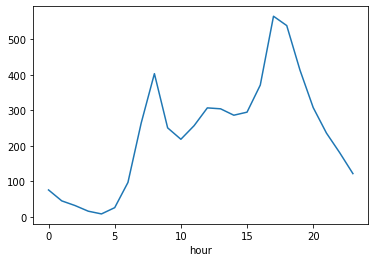

In [14]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

# Filtrar datos para la estación de verano (season = 3)
bikes_verano = bikes[bikes['season'] == 3]

# Graficar el número de bicicletas rentadas promedio para cada hora en verano
bikes_verano.groupby('hour').total.mean().plot()

En verano, la demanda de bicicletas es más alta durante las horas de la tarde y la noche, con un pico pronunciado alrededor de las 17:00 horas. Esto puede deberse a las condiciones climáticas más favorables y a las actividades recreativas al aire libre que se realizan durante el verano.

La diferencia en los patrones de alquiler entre el invierno y el verano sugiere que las estaciones del año tienen un impacto significativo en el uso de bicicletas, posiblemente debido a factores climáticos y estacionales.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [15]:
# Celda 3

# Crear variables dummy para la variable categórica 'season'
bikes_dummy = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir las variables predictoras y la variable de respuesta
X = bikes_dummy[['hour', 'season_2', 'season_3', 'season_4']]
y = bikes_dummy['total']

# Inicializar y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Imprimir los coeficientes
print("Coeficientes del modelo:")
print("Intercepto:", model.intercept_)
print("Coeficientes de 'hour':", model.coef_[0])
print("Coeficientes de 'season_2':", model.coef_[1])
print("Coeficientes de 'season_3':", model.coef_[2])
print("Coeficientes de 'season_4':", model.coef_[3])


Coeficientes del modelo:
Intercepto: -6.430262462305961
Coeficientes de 'hour': 10.545206094069886
Coeficientes de 'season_2': 100.31723191606602
Coeficientes de 'season_3': 119.46754994593182
Coeficientes de 'season_4': 84.08311787296776


### Interpretación de los coeficientes:

Hay mayor necesidad en primavera de usar la bicicleta, pues el aumento promedio de alquiler de bicicletas es de 100, sin embargo hay un aumento de 20 bicicletas alquiladas para verano y para otoño una disminución de 16 bicicletas alquiladas.

### Limitaciones de la regresión lineal en este caso:

- Linealidad: La regresión lineal asume una relación lineal entre las variables predictoras y la variable de respuesta. Sin embargo, la relación entre las variables "hour" y "total" podría no ser lineal en la realidad, especialmente si hay efectos no lineales como picos de demanda en ciertas horas del día.

- Independencia de los errores: La regresión lineal asume que los errores de predicción son independientes entre sí. En este caso, es posible que los errores estén correlacionados en el tiempo debido a la naturaleza secuencial de los datos de series temporales.

- Homocedasticidad: La regresión lineal también asume que la varianza de los errores es constante en todas las observaciones. Sin embargo, en datos de series temporales, la varianza de los errores puede cambiar con el tiempo debido a estacionalidad u otros efectos.

- Normalidad de los errores: La regresión lineal requiere que los errores de predicción sigan una distribución normal. En este caso, los errores pueden no seguir una distribución normal debido a la presencia de valores atípicos o patrones de estacionalidad en los datos.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [21]:
# Celda 4

grupo_horario = {
    'Horario Diurno': bikes[bikes['hour'] < 12],
    'Horario Nocturno': bikes[bikes['hour'] >= 12]
}

resultado = {}
for dia, base in grupo_horario.items():
    for season in sorted(base['season'].unique()):
        key = f"{dia} - Estación {season}"
        subset = base[base['season'] == season]
        resultado[key] = subset['total'].mean()
for key, mean_total in resultado.items():
    print(f"{key}: {mean_total}")


Horario Diurno - Estación 1: 75.35128983308043
Horario Diurno - Estación 2: 128.08058608058607
Horario Diurno - Estación 3: 141.26373626373626
Horario Diurno - Estación 4: 127.21010248901904
Horario Nocturno - Estación 1: 155.83698830409358
Horario Nocturno - Estación 2: 302.2309941520468
Horario Nocturno - Estación 3: 327.36622807017545
Horario Nocturno - Estación 4: 270.6615497076023


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [32]:
# Celda 5

X = bikes[['season', 'hour']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

max_depth_range = range(1, 21)

rmse_scores = []

for depth in max_depth_range:
    reg = DecisionTreeRegressor(max_depth=depth, random_state=0)
    scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    rmse_scores.append(np.mean(np.sqrt(-scores)))

optimal_depth = max_depth_range[rmse_scores.index(min(rmse_scores))]
optimal_rmse = min(rmse_scores)

arbol_regresion = DecisionTreeRegressor(max_depth=8, random_state=0)
arbol_regresion.fit(X_train, y_train)

y_pred = arbol_regresion.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE del árbol de decisión: {rmse}")

#Ajuste de la regresión lineal, predicción y cálculo del error 
model.fit(X_train, y_train)
y_pred_linear = model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

print(f"RMSE de la regresión lineal: {rmse_linear}")

RMSE del árbol de decisión: 115.21915420022897
RMSE de la regresión lineal: 163.01204038621486


Los resultados indican que el árbol de decisión tiene un RMSE (Root Mean Squared Error) de aproximadamente 115.22, mientras que la regresión lineal tiene un RMSE de aproximadamente 163.01. 

En términos generales, un RMSE más bajo indica un mejor ajuste del modelo a los datos. Por lo tanto, en este caso, el árbol de decisión parece tener un mejor desempeño en comparación con la regresión lineal, ya que tiene un RMSE más bajo. Esto sugiere que el árbol de decisión puede ser más adecuado para modelar la relación entre las variables predictoras y la variable de respuesta en este conjunto de datos en particular.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [33]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,2.0,4.702128,7.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1300.0,259.718000,0.0,843300.0,482257.142857,0.000000,6963.954292,3415.943322,4500.0,4500.0,4500.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.028582,0.028594,0.028578,0.745673,0.168573,0.625376,0.144737,0.053191,0.021277,0.714286,0.285714,0.470000,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,0.0,5.010101,8.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,919.0,250.142857,0.0,843300.0,142712.500000,0.000000,4429.750000,2610.941050,928.0,928.0,928.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.027098,0.025006,0.276713,0.025003,0.646181,0.376439,0.056574,0.030303,0.030303,0.500000,0.500000,0.342778,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,0.0,3.972376,6.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,791.0,205.666667,4800.0,843300.0,229066.666667,2440.825000,3300.698315,2895.516309,1300.0,1300.0,1300.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.033499,0.200063,0.033411,0.033334,0.699693,0.462500,0.535795,0.049724,0.000000,1.000000,0.000000,0.516263,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,0.0,4.467350,7.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1200.0,280.800000,0.0,843300.0,335642.857143,0.000000,4415.722689,2103.971787,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.457963,0.028580,0.456140,0.028627,0.028690,0.425314,0.091016,0.030730,0.023047,0.571429,0.428571,0.436654,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,0.0,5.146893,4.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,935.0,268.250000,1700.0,843300.0,258100.000000,1218.111111,3588.790194,2809.374181,2400.0,8200.0,5300.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051121,0.050014,0.050167,0.050003,0.798695,0.370238,0.148214,0.039548,0.011299,0.777778,0.222222,0.346429,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [34]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [35]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [42]:
# Celda 6

# Inicializar y ajustar el árbol de decisión
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=1)
tree_clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_tree = tree_clf.predict(X_test)

# Calcular la precisión y el F1-Score
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

print("Desempeño del árbol de decisión:")
print(f"Precisión: {accuracy_tree:.4f}")
print(f"F1-Score: {f1_tree:.4f}")

# Inicializar y ajustar la regresión logística
log_reg = LogisticRegression(random_state=1)
log_reg.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_log_reg = log_reg.predict(X_test)

# Calcular la precisión y el F1-Score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Desempeño de la regresión logística:")
print(f"Precisión: {accuracy_log_reg:.4f}")
print(f"F1-Score: {f1_log_reg:.4f}")



Desempeño del árbol de decisión:
Precisión: 0.6373
F1-Score: 0.6617
Desempeño de la regresión logística:
Precisión: 0.6147
F1-Score: 0.6110


El árbol de decisión tiene una precisión mayor que la regresión logística, pero el F1-Score es más alto para el árbol de decisión. Esto indica que el árbol de decisión tiene un mejor equilibrio entre precisión y exhaustividad en comparación con la regresión logística en este conjunto de datos.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9